In this notebook I explore <u>Bayesian Poisson modeling</u> of stranding events. I limit my exploration to the identification of intercepts (no predictive features used) as a benchmark for more complex models. 
The notebook is divided into two parts; the first part is dedicated to modeling of total number of stranding events; the second part addresses modeling of species specific stranding events.
In each part I use monthly counts first, followed by weekly counts, followed by the original daily count. I also use unpooled, pooled, and partially pooled approaches. Models and traces are identifies as belonging to 1 of these three categories by their naming:
* $x^{th}$ pooled model and trace: m_px, trace_px
* $x^{th}$ unpooled model and trace: m_ux, trace_ux
* $x^{th}$ partially pooled model and trace: m_ppx, trace_ppx

I use **counter-factual plotting** and **posterior predictive checks** (**PPC**) for model evaluation. I use the **Widely Available Information Criterion** (**WAIC**) for inter-model comparison and performance assessment.

In [160]:
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as pl
from matplotlib import rcParams
from theano import tensor as tt
import pickle
from cmocean.cm import thermal
import pathlib

In [35]:
pm.__version__

'3.2'

In [9]:
% matplotlib inline

In [10]:
rcParams['xtick.labelsize'] = 14
rcParams['ytick.labelsize'] = 14
rcParams['font.size'] = 16

In [13]:
home = pathlib.Path.home()
dataDir = home / 'DATA/Beaching_Project/PklJar'
with open(dataDir / 'CapeCodDataDict.pkl', 'rb') as f:
    dataDict = pickle.load(f)

In [15]:
df_total = dataDict['Targets']['TOTAL']

In [16]:
df_total.head()

,num_stranded,event
1999-03-07,6.0,1
1999-03-08,0.0,0
1999-03-09,0.0,0
1999-03-10,0.0,0
1999-03-11,0.0,0


First I am going to create a monthly resampled matrix and use it to create my first model.

In [17]:
df_T_M = df_total.drop('num_stranded', axis=1).resample('M').sum()

In [18]:
df_T_M.head()

,event
1999-03-31,6
1999-04-30,0
1999-05-31,0
1999-06-30,1
1999-07-31,0


In [20]:
df_T_M.describe()

,event
count,190.000000
mean,0.863158
std,1.749440
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,10.000000


In [23]:
df_T_M.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 190 entries, 1999-03-31 to 2014-12-31
Freq: M
Data columns (total 1 columns):
event    190 non-null int64
dtypes: int64(1)
memory usage: 3.0 KB


There are 190 monthly counts of stranding events spanning March 1999 to December 2014. 
Next we model only the intercepts (average stranding rates) using three strategies. For reference, note that the *monthly average stranding rate is*:

In [48]:
df_T_M.event.mean()

0.8631578947368421

In [60]:
n_obs = df_T_M.shape[0]

In [85]:
dates = np.array(df_T_M.index.to_datetime())

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 7000/7000 [00:04<00:00, 1638.04it/s]


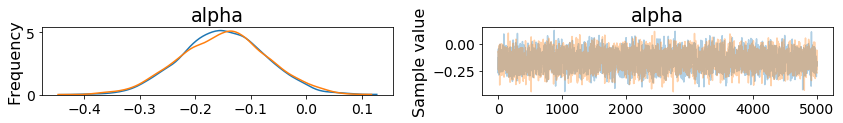

In [26]:
# pooled model
with pm.Model() as mp_0:
    alpha = pm.Normal('alpha', 0, 1)
    lambda_ = pm.math.exp(alpha)
    events_pred = pm.Poisson('events_pred', lambda_, observed=df_T_M.event)
    trace_mp0 = pm.sample(5000, tune=2000);
pm.traceplot(trace_mp0);

Next is to see what alpha corresponds to when simulating data using the results of this pooled model. Note that the pooled model implies a constant rate in time.

In [99]:
alpha_mp0_post = trace_mp0.get_values('alpha', combine=True)[:, None]
lambda_mp0_post = np.exp(alpha_mp0_post.repeat(n_obs, axis=1))
med_alpha_mp0 = np.median(lambda_mp0_post, axis=0)
hpd_95_lambda_mp0_post = pm.hpd(lambda_mp0_post)

In [108]:
ppc_mp0 = pm.sample_ppc(trace_mp0, model=mp_0, size=n_obs)['events_pred']

  0%|          | 0/5000 [00:00<?, ?it/s]


In [109]:
hpd_95_ppc_mp0 = pm.hpd(ppc_mp0)
med_ppc_mp0 = np.median(ppc_mp0, axis=0)

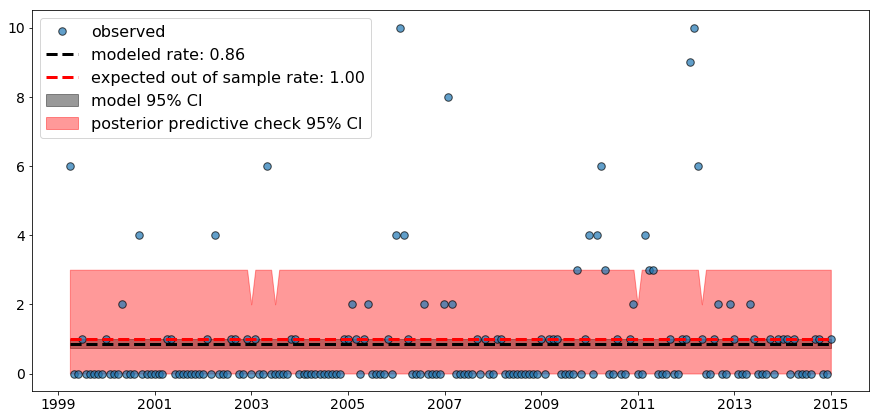

In [120]:
_, ax = pl.subplots(figsize=(15, 7))
ax.plot(dates, df_T_M.event, marker='.', markersize=15,
        markeredgecolor='k', ls='', label='observed', alpha=0.7)
ax.plot(dates, med_alpha_mp0, color='k', ls='--', lw=3,
        label='modeled rate: %.2f' % med_alpha_mp0[0])
ax.fill_between(dates, y1=hpd_95_lambda_mp0_post[:,0],
                y2=hpd_95_lambda_mp0_post[:, 1], color='k', alpha=0.4,
               label='model 95% CI');
ax.plot(dates, med_ppc_mp0, ls='--', color='r', lw=3, 
        label='expected out of sample rate: %.2f' % med_ppc_mp0[0])
ax.fill_between(dates, y1=hpd_95_ppc_mp0[:, 0], y2=hpd_95_ppc_mp0[:, 1], color='red',
               alpha=0.4, label='posterior predictive check 95% CI')
ax.legend();

The shortcomings of the pooled model are obvious here. The model (red) estimates correctly the average stranding rate of 0.86, and the PPC return a corresponding out-of-sample expectation of 1 stranding a month. However both model and PPC 95% credibility intervals (CI) fail to account for the data's overdispersion.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 7000/7000 [00:35<00:00, 199.26it/s]


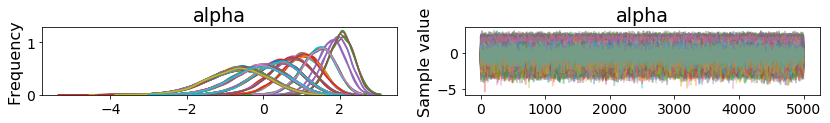

In [27]:
# unpooled model
with pm.Model() as mu_0:
    alpha = pm.Normal('alpha', 0, 1, shape=df_T_M.event.shape[0])
    lambda_ = pm.math.exp(alpha)
    events_pred = pm.Poisson('events_pred', lambda_, observed=df_T_M.event)
    trace_mu0 = pm.sample(5000, tune=2000);
pm.traceplot(trace_mu0);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 7000/7000 [00:47<00:00, 146.54it/s]


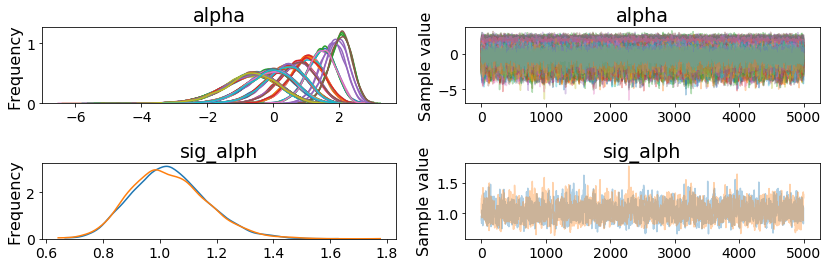

In [34]:
# partially pooled model
with pm.Model() as mpp_0:
    sig_alph = pm.HalfCauchy('sig_alph', 2)
    alpha = pm.Normal('alpha', 0, sig_alph, shape=df_T_M.event.shape[0])
    lambda_ = pm.math.exp(alpha)
    events_pred = pm.Poisson('events_pred', lambda_, observed=df_T_M.event)
    trace_mpp0 = pm.sample(5000, tune=2000)
pm.traceplot(trace_mpp0);

Inter-model comparison of intercept-only models using WAIC

In [176]:
traces = [trace_mu0, trace_mp0, trace_mpp0]
models = [mu_0, mp_0, mpp_0]
modelNames = ['mu_0', 'mp_0', 'mpp_0']

In [167]:
dfcomp = pm.compare(traces, models)
dfcomp.index = [modelNames[i] for i in dfcomp.index]
dfcomp

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
mpp_0,465.94,58.02,0,1,17.99,0,1
mu_0,466.75,57.32,0.81,0,17.86,0.57,1
mp_0,613.38,3.53,147.44,0,68.5,53.93,1


The above shows without ambiguity that the partial pooling is the better model; indeed, the weight column can be taken as the probabilility that the corresponding model will perform better than the others. Hereafter I exclusively use partially pooled models.

#### Conditioning on Month
This is my first attempt at addressing the overdispersion observed above. I'm not using any of the features available yet, just the date the event was observed. Note that inherently these models assess the probability of event being observed, rather than events occurring, since there is no guarantee tha all events will be observed.

In [124]:
df_T_M['month'] = df_T_M.index.month - 1

In [130]:
df_T_M['year'] = df_T_M.index.year

In [129]:
df_T_M.month.value_counts()

11    16
10    16
9     16
8     16
7     16
6     16
5     16
4     16
3     16
2     16
1     15
0     15
Name: month, dtype: int64

In [131]:
df_T_M.head()

,event,month,year
1999-03-31,6,2,1999
1999-04-30,0,3,1999
1999-05-31,0,4,1999
1999-06-30,1,5,1999
1999-07-31,0,6,1999


In [147]:
monAgg_Events = df_T_M.groupby('month').aggregate(np.sum)['event']

In [150]:
monYearPivot = df_T_M.pivot_table(values='event', index='year', columns='month')

In [151]:
monYearPivot

month,0,1,2,3,4,5,6,7,8,9,10,11
year,,,,,,,,,,,,
1999,NaN,NaN,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2000,0.0,0.0,0.0,2.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
2001,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2002,1.0,0.0,4.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
2003,1.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2005,2.0,1.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0
2006,10.0,4.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0
2007,8.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [ ]:
from seaborn import heatmap

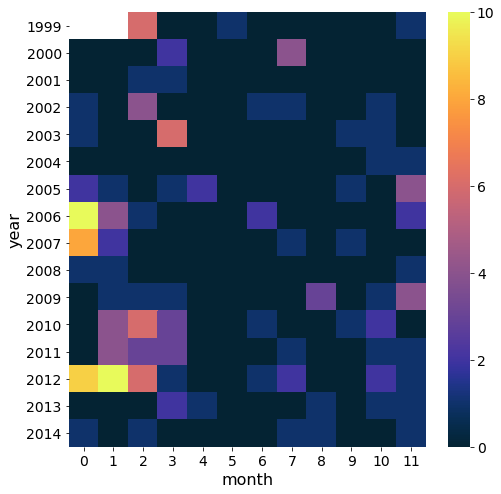

In [161]:
_, ax = pl.subplots(figsize=(8,8))
heatmap(monYearPivot, ax=ax, cmap=thermal);

In [127]:
n_months = df_T_M.month.unique().size

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 8000/8000 [00:25<00:00, 318.19it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f419a3d7128>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f419a0b16a0>]], dtype=object)

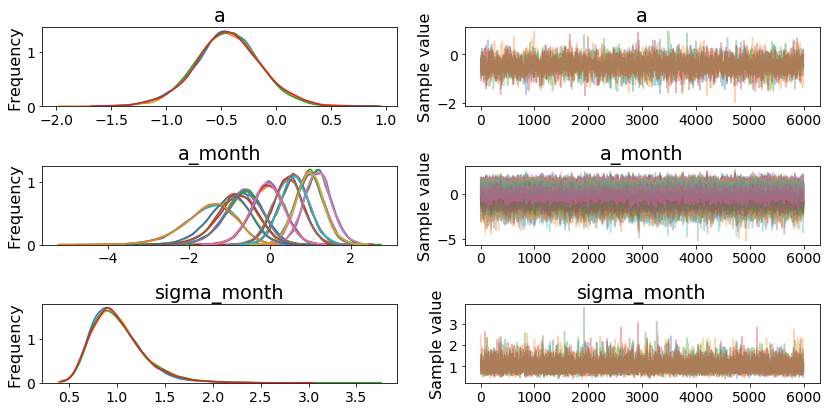

In [163]:
with pm.Model() as mpp_1:
    a = pm.Normal('a', 0, 1)
    sigma_month = pm.HalfCauchy('sigma_month', 1)
    a_month = pm.Normal('a_month', 0, sigma_month, shape=n_months)
    lambda_ = pm.math.exp(a + a_month[df_T_M.month.values])
    events_pred = pm.Poisson('events_pred', lambda_, observed=df_T_M.event)
    trace_mpp1 = pm.sample(6000, tune=2000, chains=4)
pm.traceplot(trace_mpp1);

In [166]:
trace_mpp1.nchains

4

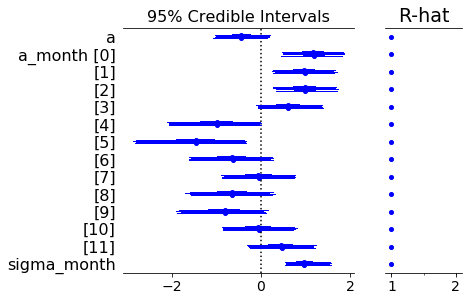

In [165]:
pm.forestplot(trace_mpp1);

In [177]:
traces.append(trace_mpp1)
models.append(mpp_1)
modelNames.append('mpp_1')

In [183]:
df_comp = pm.compare(traces, models, ic='LOO')
df_comp.index = [modelNames[i] for i in df_comp.index]
df_comp

,LOO,pLOO,dLOO,weight,SE,dSE,warning
mpp_0,501.09,75.6,0,0.45,21.23,0,1
mu_0,503.12,75.5,2.04,0,21.63,2.01,1
mpp_1,538.81,23.71,37.73,0.55,49.6,32.43,0
mp_0,613.39,3.53,112.3,0,68.51,50.16,0


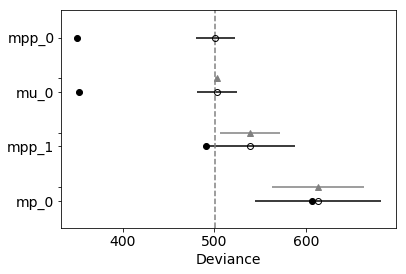

In [185]:
ax = pm.compareplot(df_comp)

In [188]:
with pm.Model() as mpp_2:
    a = pm.Normal('a', 0, 1)
    sigma_month = pm.HalfCauchy('sigma_month', 1)
    sigma_event = pm.HalfCauchy('sigma_event', 1)
    a_event = pm.Normal('a_event', 0, sigma_event, shape=df_T_M.shape[0])
    a_month = pm.Normal('a_month', 0, sigma_month, shape=n_months)
    lambda_ = pm.math.exp(a + a_event + a_month[df_T_M.month.values])
    events_pred = pm.Poisson('events_pred', lambda_, observed=df_T_M.event)
    trace_mpp2 = pm.sample(6000, tune=2000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 8000/8000 [00:49<00:00, 162.07it/s]
